In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg

In [2]:


torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
criticItr = 5
lambda_GP = 10


Device: cuda


In [3]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


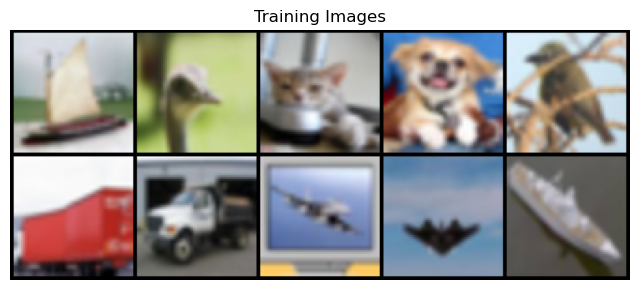

In [4]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('Results/WGANGP_RealImg.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
           
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine =True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
           
            self.Gnet(channels_noise, features_g*8, 4, 1, 0),           
            self.Gnet(features_g*8, features_g*4, 4, 2, 1),  
            self.Gnet(features_g*4, features_g*2, 4, 2, 1),  
            self.Gnet(features_g*2, features_g, 4, 2, 1),      
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh() 
        
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)



In [6]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def GP (critic, real, fake):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty



In [7]:
import os
if not os.path.exists('Models'):
   os.makedirs('Models')

def save_model(model):
    if model == 'gen':
        print("Saving model Generator. ")
        torch.save(model, "Models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif model == 'disc':
        print("Saving model Discriminator. ")
        torch.save(model, "Models/CIFAR_wganGP_DIS.pth.tar")
        
def load_model(gen,disc):
    print("Loading Models.. ")
    gen = torch.load("Models/CIFAR_wganGP_GENERATOR.pth.tar")
    disc = torch.load("Models/CIFAR_wganGP_DIS.pth.tar")



In [8]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)
optimGen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optimDisc = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
step = 0

In [9]:


gen.train() , disc.train()



(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [10]:
class InceptionV3Model(nn.Module):
    
    DEFAULT_BLOCK_INDEX = 3
    LAYER_INDEX_BY_SIZE = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_layers=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3Model, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_layers = sorted(output_layers)
        self.last_needed_layer = max(output_layers)

        assert self.last_needed_layer <= 3, \
            'Last possible output block index is 3'

        self.layer_blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.layer_blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_layer >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.layer_blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_layer >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.layer_blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_layer >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.layer_blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.layer_blocks):
            x = block(x)
            if idx in self.output_layers:
                outp.append(x)

            if idx == self.last_needed_layer:
                break

        return outp
    
block_idx = InceptionV3Model.LAYER_INDEX_BY_SIZE[2048]
model = InceptionV3Model([block_idx])
model=model.cuda()

def compute_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    activations = model(batch)[0]
    if activations.size(2) != 1 or activations.size(3) != 1:
        activations = adaptive_avg_pool2d(activations, output_size=(1, 1))

    act= activations.cpu().data.numpy().reshape(activations.size(0), -1)
    
    mean_value = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mean_value, sigma


def sqrtm_approximation(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring method
        U, s, V = np.linalg.svd(A)
        s = np.diag(np.sqrt(s))
        return U.dot(s).dot(V)
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + A.dot(np.linalg.inv(X)))
            if np.max(np.abs(X - Y)) < tol:
                break
            X = Y
        return X
    else:
        raise ValueError("Invalid method: %s" % method)
            
def compute_frechet_distance(mean1, sigma1, mean2, sigma2, eps=1e-6):
    mean1 = np.atleast_1d(mean1)
    mean2 = np.atleast_1d(mean2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mean1.shape == mean2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mean1 - mean2
    
    covariance_mean = sqrtm_approximation(sigma1.dot(sigma2), 'ss')

    if not np.isfinite(covariance_mean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps

        offset = np.eye(sigma1.shape[0]) * eps
        covariance_mean = sqrtm_approximation((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covariance_mean):
        if not np.allclose(np.diagonal(covariance_mean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covariance_mean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covariance_mean = covariance_mean.real
    tr_covariance_mean = np.trace(covariance_mean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covariance_mean)

def calculate_frechet_distance_score(images_real,images_fake,model):
    mean_real,cov_real=compute_activation_statistics(images_real,model,cuda=True)
    mean_fake,cov_fake=compute_activation_statistics(images_fake,model,cuda=True)
    
    """get  the fretchet distance"""
    frechet_distance = compute_frechet_distance(mean_real, cov_real, mean_fake, cov_fake)
    return frechet_distance

/home/tvaspar/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tvaspar/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
gen_loss_values = []
disc_loss_values = []
disc_loss_per_iter = []
image_list = []
iterations = 0
fid_scores = []

print("Training Started")
# record the start timing
training_start_time = time.time()
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
    for batch_idx, data in enumerate(dataloader,0):
       
        real = data[0].to(device)
        batch = real.shape[0]
       
        for i in range (criticItr):
            noise = torch.randn(batch, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise) #genrator img data
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            gp = GP(disc, real,fake)
            critic_loss = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ (lambda_GP*gp))
            disc.zero_grad()
            critic_loss.backward(retain_graph=True)
            optimDisc.step()

        output = disc(fake).reshape(-1)
        gen_loss = -torch.mean(output) 
        gen.zero_grad()
        gen_loss.backward()
        optimGen.step()

        gen_loss_values.append(gen_loss.detach().cpu())
        disc_loss_values.append(critic_loss.detach().cpu())

        
        if (iterations % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            image_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iterations += 1
        
    frechet_distance=calculate_frechet_distance_score(real,fake,model)
    fid_scores.append(frechet_distance)
    print(f"Epoch No.  [{epoch}/{NUM_EPOCHS}] Batch No. {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {critic_loss:.3f}, loss Generator: {gen_loss:.3f}, FID Score: {frechet_distance:.3f} ", end="\r", flush=True) 
    
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = gen(fixed_noise)
    if not os.path.exists('Results/WGANGP_FAKE'):
       os.makedirs('Results/WGANGP_FAKE')
    if not os.path.exists('Results/WGANGP_REAL'):
       os.makedirs('Results/WGANGP_REAL')
    utils.save_image(images.detach(),'Results/WGANGP_FAKE/WGANGP_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
    real = data[0].to(device)
    utils.save_image(real.detach(),'Results/WGANGP_REAL/WGANGP_epoch_%03d.png' % (epoch), normalize = True)
        
        
training_end_time = time.time()
print('\n\n elapsed time：%.2f s.'%(training_end_time-training_start_time))

Training Started
Epoch No.  [40/40] Batch No. 1562/1563                   Loss Discriminator: -12.778, loss Generator: 248.287, FID Score: 327.162 

 elapsed time：3682.10 s.


In [12]:
if not os.path.exists('Results/Loss_Data'):
       os.makedirs('Results/Loss_Data')

In [13]:
np.save('Results/Loss_Data/WGANGP_GLoss', gen_loss_values) 
np.save('Results/Loss_Data/WGANGP_DLoss', disc_loss_values) 
gen_loss_values = np.load('Results/Loss_Data/WGANGP_GLoss.npy')
disc_loss_values = np.load('Results/Loss_Data/WGANGP_DLoss.npy')

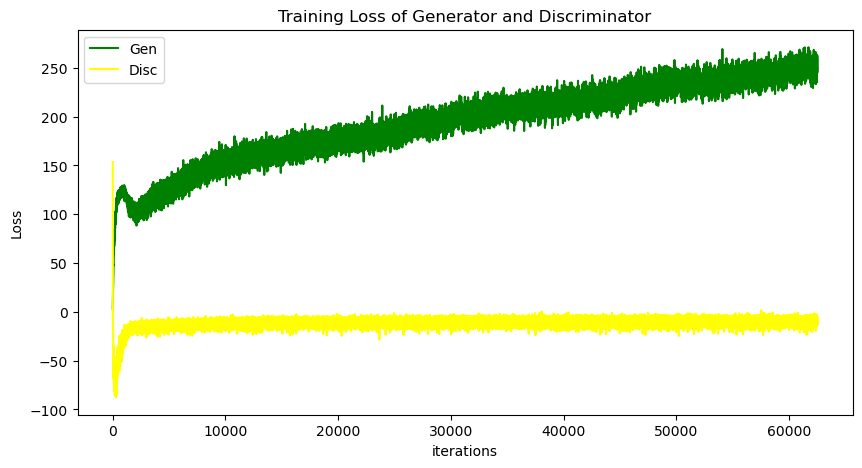

In [14]:
plt.figure(figsize=(10,5))
plt.title("Training Loss of Generator and Discriminator")
plt.plot(gen_loss_values,label="Gen", color='green')
plt.plot(disc_loss_values,label="Disc", color='yellow')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/Loss.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()

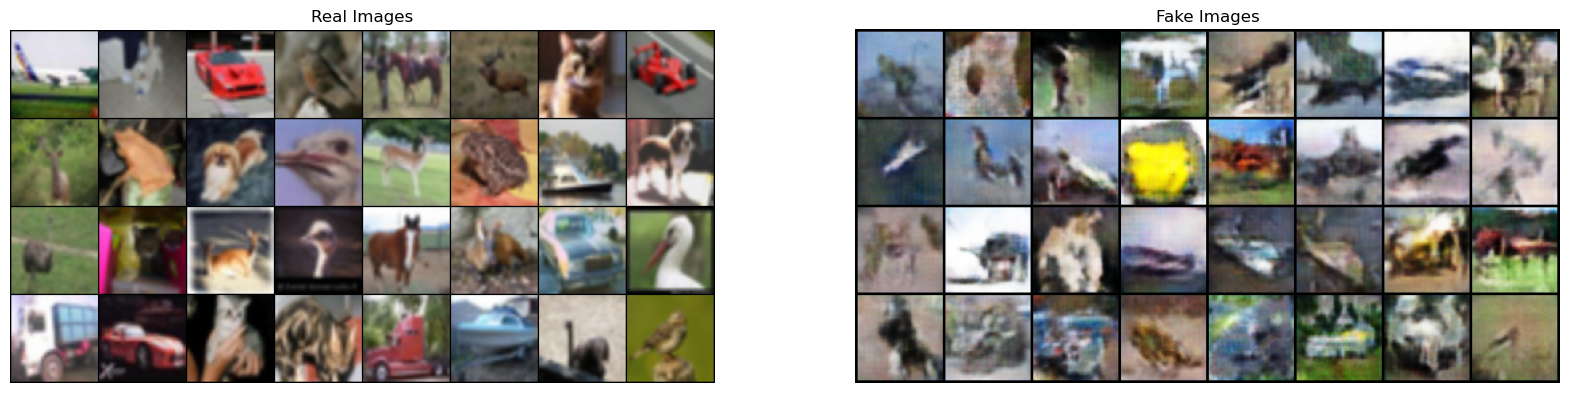

In [15]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(image_list[-1],(1,2,0)))
plt.savefig('Results/WGANGP_BEST_FAKE_32.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()

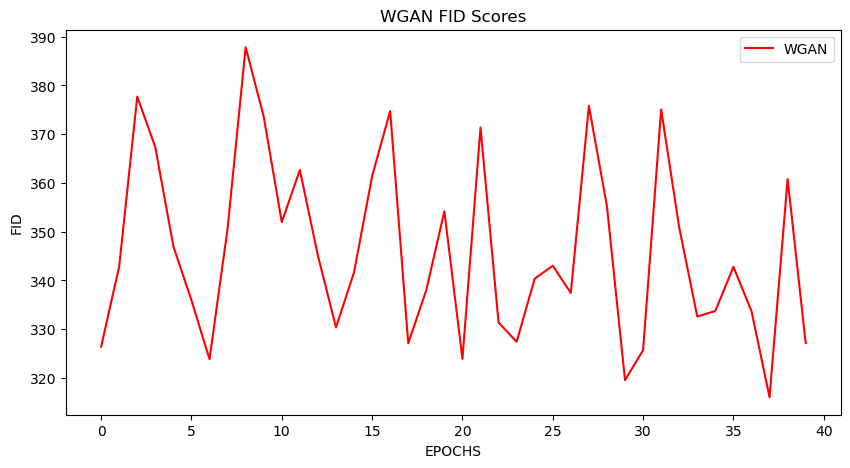

In [16]:
plt.figure(figsize=(10,5))
plt.title("WGAN FID Scores")
plt.plot(fid_scores,label="WGAN", color='red')
plt.xlabel("EPOCHS")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID.pdf',
            format='pdf',
            bbox_inches='tight')
plt.show()



In [17]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/WGAN_FID', fid_scores) 

In [18]:
np.min(fid_scores), np.max(fid_scores), np.mean(fid_scores), fid_scores[-5]

(316.05067267084115, 387.83280908856545, 346.10385781200284, 342.7907028836055)

In [19]:
np.mean(gen_loss_values),np.mean(disc_loss_values),np.min(gen_loss_values),np.min(disc_loss_values),gen_loss_values[-1],disc_loss_values[-1]

(192.78209, -10.889592, 3.2544417, -87.50342, 248.28723, -12.777964)